# Project: Part of Speech Tagging with Hidden Markov Models 
---
### Introduction

Part of speech tagging is the process of determining the syntactic category of a word from the words in its surrounding context. It is often used to help disambiguate natural language phrases because it can be done quickly with high accuracy. Tagging can be used for many NLP tasks like determining correct pronunciation during speech synthesis (for example, _dis_-count as a noun vs dis-_count_ as a verb), for information retrieval, and for word sense disambiguation.

In this notebook, you'll use the [Pomegranate](http://pomegranate.readthedocs.io/) library to build a hidden Markov model for part of speech tagging using a "universal" tagset. Hidden Markov models have been able to achieve [>96% tag accuracy with larger tagsets on realistic text corpora](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf). Hidden Markov models have also been used for speech recognition and speech generation, machine translation, gene recognition for bioinformatics, and human gesture recognition for computer vision, and more. 

![](_post-hmm.png)

The notebook already contains some code to get you started. You only need to add some new functionality in the areas indicated to complete the project; you will not need to modify the included code beyond what is requested. Sections that begin with **'IMPLEMENTATION'** in the header indicate that you must provide code in the block that follows. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully!

<div class="alert alert-block alert-info">
**Note:** Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You must then **export the notebook** by running the last cell in the notebook, or by using the menu above and navigating to **File -> Download as -> HTML (.html)** Your submissions should include both the `html` and `ipynb` files.
</div>

<div class="alert alert-block alert-info">
**Note:** Code and Markdown cells can be executed using the `Shift + Enter` keyboard shortcut. Markdown cells can be edited by double-clicking the cell to enter edit mode.
</div>

### The Road Ahead
You must complete Steps 1-3 below to pass the project. The section on Step 4 includes references & resources you can use to further explore HMM taggers.

- [Step 1](#Step-1:-Read-and-preprocess-the-dataset): Review the provided interface to load and access the text corpus
- [Step 2](#Step-2:-Build-a-Most-Frequent-Class-tagger): Build a Most Frequent Class tagger to use as a baseline
- [Step 3](#Step-3:-Build-an-HMM-tagger): Build an HMM Part of Speech tagger and compare to the MFC baseline
- [Step 4](#Step-4:-[Optional]-Improving-model-performance): (Optional) Improve the HMM tagger

In [1]:
# Jupyter "magic methods" -- only need to be run once per kernel restart
%load_ext autoreload
%aimport helpers, tests
%autoreload 1

In [2]:
# import python modules -- this cell needs to be run again if you make changes to any of the files
import matplotlib.pyplot as plt
import numpy as np

from IPython.core.display import HTML
from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

## Step 1: Read and preprocess the dataset
---
We'll start by reading in a text corpus and splitting it into a training and testing dataset. The data set is a copy of the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) (originally from the [NLTK](https://www.nltk.org/) library) that has already been pre-processed to only include the [universal tagset](https://arxiv.org/pdf/1104.2086.pdf). You should expect to get slightly higher accuracy using this simplified tagset than the same model would achieve on a larger tagset like the full [Penn treebank tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html), but the process you'll follow would be the same.

The `Dataset` class provided in helpers.py will read and parse the corpus. You can generate your own datasets compatible with the reader by writing them to the following format. The dataset is stored in plaintext as a collection of words and corresponding tags. Each sentence starts with a unique identifier on the first line, followed by one tab-separated word/tag pair on each following line. Sentences are separated by a single blank line.

Example from the Brown corpus. 
```
b100-38532
Perhaps	ADV
it	PRON
was	VERB
right	ADJ
;	.
;	.

b100-35577
...
```

In [3]:
data = Dataset("tags-universal.txt", "brown-universal.txt", train_test_split=0.8)

print("There are {} sentences in the corpus.".format(len(data)))
print("There are {} sentences in the training set.".format(len(data.training_set)))
print("There are {} sentences in the testing set.".format(len(data.testing_set)))

assert len(data) == len(data.training_set) + len(data.testing_set), \
       "The number of sentences in the training set + testing set should sum to the number of sentences in the corpus"

There are 57340 sentences in the corpus.
There are 45872 sentences in the training set.
There are 11468 sentences in the testing set.


### The Dataset Interface

You can access (mostly) immutable references to the dataset through a simple interface provided through the `Dataset` class, which represents an iterable collection of sentences along with easy access to partitions of the data for training & testing. Review the reference below, then run and review the next few cells to make sure you understand the interface before moving on to the next step.

```
Dataset-only Attributes:
    training_set - reference to a Subset object containing the samples for training
    testing_set - reference to a Subset object containing the samples for testing

Dataset & Subset Attributes:
    sentences - a dictionary with an entry {sentence_key: Sentence()} for each sentence in the corpus
    keys - an immutable ordered (not sorted) collection of the sentence_keys for the corpus
    vocab - an immutable collection of the unique words in the corpus
    tagset - an immutable collection of the unique tags in the corpus
    X - returns an array of words grouped by sentences ((w11, w12, w13, ...), (w21, w22, w23, ...), ...)
    Y - returns an array of tags grouped by sentences ((t11, t12, t13, ...), (t21, t22, t23, ...), ...)
    N - returns the number of distinct samples (individual words or tags) in the dataset

Methods:
    stream() - returns an flat iterable over all (word, tag) pairs across all sentences in the corpus
    __iter__() - returns an iterable over the data as (sentence_key, Sentence()) pairs
    __len__() - returns the nubmer of sentences in the dataset
```

For example, consider a Subset, `subset`, of the sentences `{"s0": Sentence(("See", "Spot", "run"), ("VERB", "NOUN", "VERB")), "s1": Sentence(("Spot", "ran"), ("NOUN", "VERB"))}`. The subset will have these attributes:

```
subset.keys == {"s1", "s0"}  # unordered
subset.vocab == {"See", "run", "ran", "Spot"}  # unordered
subset.tagset == {"VERB", "NOUN"}  # unordered
subset.X == (("Spot", "ran"), ("See", "Spot", "run"))  # order matches .keys
subset.Y == (("NOUN", "VERB"), ("VERB", "NOUN", "VERB"))  # order matches .keys
subset.N == 7  # there are a total of seven observations over all sentences
len(subset) == 2  # because there are two sentences
```

<div class="alert alert-block alert-info">
**Note:** The `Dataset` class is _convenient_, but it is **not** efficient. It is not suitable for huge datasets because it stores multiple redundant copies of the same data.
</div>

#### Sentences

`Dataset.sentences` is a dictionary of all sentences in the training corpus, each keyed to a unique sentence identifier. Each `Sentence` is itself an object with two attributes: a tuple of the words in the sentence named `words` and a tuple of the tag corresponding to each word named `tags`.

In [4]:
key = 'b100-38532'
print("Sentence: {}".format(key))
print("words:\n\t{!s}".format(data.sentences[key].words))
print("tags:\n\t{!s}".format(data.sentences[key].tags))

Sentence: b100-38532
words:
	('Perhaps', 'it', 'was', 'right', ';', ';')
tags:
	('ADV', 'PRON', 'VERB', 'ADJ', '.', '.')


<div class="alert alert-block alert-info">
**Note:** The underlying iterable sequence is **unordered** over the sentences in the corpus; it is not guaranteed to return the sentences in a consistent order between calls. Use `Dataset.stream()`, `Dataset.keys`, `Dataset.X`, or `Dataset.Y` attributes if you need ordered access to the data.
</div>

#### Counting Unique Elements

You can access the list of unique words (the dataset vocabulary) via `Dataset.vocab` and the unique list of tags via `Dataset.tagset`.

In [5]:
print("There are a total of {} samples of {} unique words in the corpus."
      .format(data.N, len(data.vocab)))
print("There are {} samples of {} unique words in the training set."
      .format(data.training_set.N, len(data.training_set.vocab)))
print("There are {} samples of {} unique words in the testing set."
      .format(data.testing_set.N, len(data.testing_set.vocab)))
print("There are {} words in the test set that are missing in the training set."
      .format(len(data.testing_set.vocab - data.training_set.vocab)))

assert data.N == data.training_set.N + data.testing_set.N, \
       "The number of training + test samples should sum to the total number of samples"

There are a total of 1161192 samples of 56057 unique words in the corpus.
There are 928458 samples of 50536 unique words in the training set.
There are 232734 samples of 25112 unique words in the testing set.
There are 5521 words in the test set that are missing in the training set.


#### Accessing word and tag Sequences
The `Dataset.X` and `Dataset.Y` attributes provide access to ordered collections of matching word and tag sequences for each sentence in the dataset.

In [6]:
# accessing words with Dataset.X and tags with Dataset.Y 
for i in range(2):    
    print("Sentence {}:".format(i + 1), data.X[i])
    print()
    print("Labels {}:".format(i + 1), data.Y[i])
    print()

Sentence 1: ('Mr.', 'Podger', 'had', 'thanked', 'him', 'gravely', ',', 'and', 'now', 'he', 'made', 'use', 'of', 'the', 'advice', '.')

Labels 1: ('NOUN', 'NOUN', 'VERB', 'VERB', 'PRON', 'ADV', '.', 'CONJ', 'ADV', 'PRON', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', '.')

Sentence 2: ('But', 'there', 'seemed', 'to', 'be', 'some', 'difference', 'of', 'opinion', 'as', 'to', 'how', 'far', 'the', 'board', 'should', 'go', ',', 'and', 'whose', 'advice', 'it', 'should', 'follow', '.')

Labels 2: ('CONJ', 'PRT', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'ADP', 'ADV', 'ADV', 'DET', 'NOUN', 'VERB', 'VERB', '.', 'CONJ', 'DET', 'NOUN', 'PRON', 'VERB', 'VERB', '.')



#### Accessing (word, tag) Samples
The `Dataset.stream()` method returns an iterator that chains together every pair of (word, tag) entries across all sentences in the entire corpus.

In [7]:
# use Dataset.stream() (word, tag) samples for the entire corpus
print("\nStream (word, tag) pairs:\n")
for i, pair in enumerate(data.stream()):
    print("\t", pair)
    if i > 5: break


Stream (word, tag) pairs:

	 ('Mr.', 'NOUN')
	 ('Podger', 'NOUN')
	 ('had', 'VERB')
	 ('thanked', 'VERB')
	 ('him', 'PRON')
	 ('gravely', 'ADV')
	 (',', '.')



For both our baseline tagger and the HMM model we'll build, we need to estimate the frequency of tags & words from the frequency counts of observations in the training corpus. In the next several cells you will complete functions to compute the counts of several sets of counts. 

## Step 2: Build a Most Frequent Class tagger
---

Perhaps the simplest tagger (and a good baseline for tagger performance) is to simply choose the tag most frequently assigned to each word. This "most frequent class" tagger inspects each observed word in the sequence and assigns it the label that was most often assigned to that word in the corpus.

### IMPLEMENTATION: Pair Counts

Complete the function below that computes the joint frequency counts for two input sequences.

In [8]:
from collections import defaultdict

def pair_counts(sequences_A, sequences_B):
    """Return a dictionary keyed to each unique value in the first sequence list
    that counts the number of occurrences of the corresponding value from the
    second sequences list.
    
    For example, if sequences_A is tags and sequences_B is the corresponding
    words, then if 1244 sequences contain the word "time" tagged as a NOUN, then
    you should return a dictionary such that pair_counts[NOUN][time] == 1244
    """
    freqs = defaultdict(lambda: defaultdict(int))
    for a, b in zip(sequences_A, sequences_B):
        freqs[a][b] += 1
    return dict({key: dict(value) for key, value in freqs.items()})


# Calculate C(t_i, w_i)
words, tags = list(zip(*data.stream()))
emission_counts = pair_counts(tags, words)

assert len(emission_counts) == 12, \
       "Uh oh. There should be 12 tags in your dictionary."
assert max(emission_counts["NOUN"], key=emission_counts["NOUN"].get) == 'time', \
       "Hmmm...'time' is expected to be the most common NOUN."
HTML('<div class="alert alert-block alert-success">Your emission counts look good!</div>')

### IMPLEMENTATION: Most Frequent Class Tagger

Use the `pair_counts()` function and the training dataset to find the most frequent class label for each word in the training data, and populate the `mfc_table` below. The table keys should be words, and the values should be the appropriate tag string.

The `MFCTagger` class is provided to mock the interface of Pomegranate HMM models so that they can be used interchangeably.

In [9]:
# Create a lookup table mfc_table where mfc_table[word] contains the tag label most frequently assigned to that word
from collections import namedtuple

FakeState = namedtuple("FakeState", "name")

class MFCTagger:
    # NOTE: You should not need to modify this class or any of its methods
    missing = FakeState(name="<MISSING>")
    
    def __init__(self, table):
        self.table = defaultdict(lambda: MFCTagger.missing)
        self.table.update({word: FakeState(name=tag) for word, tag in table.items()})
        
    def viterbi(self, seq):
        """This method simplifies predictions by matching the Pomegranate viterbi() interface"""
        return 0., list(enumerate(["<start>"] + [self.table[w] for w in seq] + ["<end>"]))


# TODO: calculate the frequency of each tag being assigned to each word (hint: similar, but not
# the same as the emission probabilities) and use it to fill the mfc_table

word_counts = pair_counts(*zip(*data.training_set.stream()))

mfc_table = {key: max(((k, v) for k,v in value.items()), key=lambda x: x[1])[0] 
             for key, value in word_counts.items()}

# DO NOT MODIFY BELOW THIS LINE
mfc_model = MFCTagger(mfc_table) # Create a Most Frequent Class tagger instance

assert len(mfc_table) == len(data.training_set.vocab), ""
assert all(k in data.training_set.vocab for k in mfc_table.keys()), ""
assert sum(int(k not in mfc_table) for k in data.testing_set.vocab) == 5521, ""
HTML('<div class="alert alert-block alert-success">Your MFC tagger has all the correct words!</div>')

### Making Predictions with a Model
The helper functions provided below interface with Pomegranate network models & the mocked MFCTagger to take advantage of the [missing value](http://pomegranate.readthedocs.io/en/latest/nan.html) functionality in Pomegranate through a simple sequence decoding function. Run these functions, then run the next cell to see some of the predictions made by the MFC tagger.

In [10]:
def replace_unknown(sequence):
    """Return a copy of the input sequence where each unknown word is replaced
    by the literal string value 'nan'. Pomegranate will ignore these values
    during computation.
    """
    return [w if w in data.training_set.vocab else 'nan' for w in sequence]

def simplify_decoding(X, model):
    """X should be a 1-D sequence of observations for the model to predict"""
    _, state_path = model.viterbi(replace_unknown(X))
    return [state[1].name for state in state_path[1:-1]]  # do not show the start/end state predictions

### Example Decoding Sequences with MFC Tagger

In [11]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, mfc_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', '<MISSING>', 'ADP', 'ADJ', 'ADJ', 

### Evaluating Model Accuracy

The function below will evaluate the accuracy of the MFC tagger on the collection of all sentences from a text corpus. 

In [12]:
def accuracy(X, Y, model):
    """Calculate the prediction accuracy by using the model to decode each sequence
    in the input X and comparing the prediction with the true labels in Y.
    
    The X should be an array whose first dimension is the number of sentences to test,
    and each element of the array should be an iterable of the words in the sequence.
    The arrays X and Y should have the exact same shape.
    
    X = [("See", "Spot", "run"), ("Run", "Spot", "run", "fast"), ...]
    Y = [(), (), ...]
    """
    correct = total_predictions = 0
    for observations, actual_tags in zip(X, Y):
        
        # The model.viterbi call in simplify_decoding will return None if the HMM
        # raises an error (for example, if a test sentence contains a word that
        # is out of vocabulary for the training set). Any exception counts the
        # full sentence as an error (which makes this a conservative estimate).
        try:
            most_likely_tags = simplify_decoding(observations, model)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct / total_predictions

#### Evaluate the accuracy of the MFC tagger
Run the next cell to evaluate the accuracy of the tagger on the training and test corpus.

In [13]:
mfc_training_acc = accuracy(data.training_set.X, data.training_set.Y, mfc_model)
print("training accuracy mfc_model: {:.2f}%".format(100 * mfc_training_acc))

mfc_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, mfc_model)
print("testing accuracy mfc_model: {:.2f}%".format(100 * mfc_testing_acc))

assert mfc_training_acc >= 0.955, "Uh oh. Your MFC accuracy on the training set doesn't look right."
assert mfc_testing_acc >= 0.925, "Uh oh. Your MFC accuracy on the testing set doesn't look right."
HTML('<div class="alert alert-block alert-success">Your MFC tagger accuracy looks correct!</div>')

training accuracy mfc_model: 95.72%
testing accuracy mfc_model: 93.02%


## Step 3: Build an HMM tagger
---
The HMM tagger has one hidden state for each possible tag, and parameterized by two distributions: the emission probabilties giving the conditional probability of observing a given **word** from each hidden state, and the transition probabilities giving the conditional probability of moving between **tags** during the sequence.

We will also estimate the starting probability distribution (the probability of each **tag** being the first tag in a sequence), and the terminal probability distribution (the probability of each **tag** being the last tag in a sequence).

The maximum likelihood estimate of these distributions can be calculated from the frequency counts as described in the following sections where you'll implement functions to count the frequencies, and finally build the model. The HMM model will make predictions according to the formula:

$$t_i^n = \underset{t_i^n}{\mathrm{argmax}} \prod_{i=1}^n P(w_i|t_i) P(t_i|t_{i-1})$$

Refer to Speech & Language Processing [Chapter 10](https://web.stanford.edu/~jurafsky/slp3/10.pdf) for more information.

### IMPLEMENTATION: Unigram Counts

Complete the function below to estimate the co-occurrence frequency of each symbol over all of the input sequences. The unigram probabilities in our HMM model are estimated from the formula below, where N is the total number of samples in the input. (You only need to compute the counts for now.)

$$P(tag_1) = \frac{C(tag_1)}{N}$$

In [14]:
from collections import defaultdict
from itertools import chain

def unigram_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequence list that
    counts the number of occurrences of the value in the sequences list. The sequences
    collection should be a 2-dimensional array.
    
    For example, if the tag NOUN appears 275558 times over all the input sequences,
    then you should return a dictionary such that your_unigram_counts[NOUN] == 275558.
    """
    counts = defaultdict(int)
    elements = list(chain(*sequences))
    for e in elements:
        counts[e] += 1
    return dict(counts)

# TODO: call unigram_counts with a list of tag sequences from the training set
tag_unigrams = unigram_counts(data.training_set.Y)

assert set(tag_unigrams.keys()) == data.training_set.tagset, \
       "Uh oh. It looks like your tag counts doesn't include all the tags!"
assert min(tag_unigrams, key=tag_unigrams.get) == 'X', \
       "Hmmm...'X' is expected to be the least common class"
assert max(tag_unigrams, key=tag_unigrams.get) == 'NOUN', \
       "Hmmm...'NOUN' is expected to be the most common class"
HTML('<div class="alert alert-block alert-success">Your tag unigrams look good!</div>')

### IMPLEMENTATION: Bigram Counts

Complete the function below to estimate the co-occurrence frequency of each pair of symbols in each of the input sequences. These counts are used in the HMM model to estimate the bigram probability of two tags from the frequency counts according to the formula: $$P(tag_2|tag_1) = \frac{C(tag_2|tag_1)}{C(tag_2)}$$


In [15]:
def bigram_counts(sequences):
    """Return a dictionary keyed to each unique PAIR of values in the input sequences
    list that counts the number of occurrences of pair in the sequences list. The input
    should be a 2-dimensional array.
    
    For example, if the pair of tags (NOUN, VERB) appear 61582 times, then you should
    return a dictionary such that your_bigram_counts[(NOUN, VERB)] == 61582
    """
    counts = defaultdict(int)
    elements = chain(*map(lambda x: [(x[i], x[i+1]) for i in range(len(x)-1)],
                          sequences))
    for e in elements:
        counts[e] += 1
    return dict(counts)

# TODO: call bigram_counts with a list of tag sequences from the training set
tag_bigrams = bigram_counts(data.training_set.Y)

assert len(tag_bigrams) == 144, \
       "Uh oh. There should be 144 pairs of bigrams (12 tags x 12 tags)"
assert min(tag_bigrams, key=tag_bigrams.get) in [('X', 'NUM'), ('PRON', 'X')], \
       "Hmmm...The least common bigram should be one of ('X', 'NUM') or ('PRON', 'X')."
assert max(tag_bigrams, key=tag_bigrams.get) in [('DET', 'NOUN')], \
       "Hmmm...('DET', 'NOUN') is expected to be the most common bigram."
HTML('<div class="alert alert-block alert-success">Your tag bigrams look good!</div>')

### IMPLEMENTATION: Sequence Starting Counts
Complete the code below to estimate the bigram probabilities of a sequence starting with each tag.

In [16]:
from itertools import chain
from collections import defaultdict

def starting_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the beginning of
    a sequence.
    
    For example, if 8093 sequences start with NOUN, then you should return a
    dictionary such that your_starting_counts[NOUN] == 8093
    """
    counts = defaultdict(int)
    elements = map(lambda x: x[0], sequences)
    for e in elements:
        counts[e] += 1
    return dict(counts)

# TODO: Calculate the count of each tag starting a sequence
tag_starts = starting_counts(data.training_set.Y)

assert len(tag_starts) == 12, "Uh oh. There should be 12 tags in your dictionary."
assert min(tag_starts, key=tag_starts.get) == 'X', "Hmmm...'X' is expected to be the least common starting bigram."
assert max(tag_starts, key=tag_starts.get) == 'DET', "Hmmm...'DET' is expected to be the most common starting bigram."
HTML('<div class="alert alert-block alert-success">Your starting tag counts look good!</div>')

### IMPLEMENTATION: Sequence Ending Counts
Complete the function below to estimate the bigram probabilities of a sequence ending with each tag.

In [17]:
def ending_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the end of
    a sequence.
    
    For example, if 18 sequences end with DET, then you should return a
    dictionary such that your_starting_counts[DET] == 18
    """
    counts = defaultdict(int)
    elements = map(lambda x: x[-1], sequences)
    for e in elements:
        counts[e] += 1
    return dict(counts)

# TODO: Calculate the count of each tag ending a sequence
tag_ends = ending_counts(data.training_set.Y)

assert len(tag_ends) == 12, "Uh oh. There should be 12 tags in your dictionary."
assert min(tag_ends, key=tag_ends.get) in ['X', 'CONJ'], "Hmmm...'X' or 'CONJ' should be the least common ending bigram."
assert max(tag_ends, key=tag_ends.get) == '.', "Hmmm...'.' is expected to be the most common ending bigram."
HTML('<div class="alert alert-block alert-success">Your ending tag counts look good!</div>')

### IMPLEMENTATION: Basic HMM Tagger
Use the tag unigrams and bigrams calculated above to construct a hidden Markov tagger.

- Add one state per tag
    - The emission distribution at each state should be estimated with the formula: $P(w|t) = \frac{C(t, w)}{C(t)}$
- Add an edge from the starting state `basic_model.start` to each tag
    - The transition probability should be estimated with the formula: $P(t|start) = \frac{C(start, t)}{C(start)}$
- Add an edge from each tag to the end state `basic_model.end`
    - The transition probability should be estimated with the formula: $P(end|t) = \frac{C(t, end)}{C(t)}$
- Add an edge between _every_ pair of tags
    - The transition probability should be estimated with the formula: $P(t_2|t_1) = \frac{C(t_1, t_2)}{C(t_1)}$

In [18]:
basic_model = HiddenMarkovModel(name="base-hmm-tagger")

# TODO: create states with emission probability distributions P(word | tag) and add to the model
# (Hint: you may need to loop & create/add new states)
states = [
    State(DiscreteDistribution({key: value / tag_unigrams[tag] 
                                for key, value in emission_counts[tag].items()}), tag)
    for tag in data.training_set.tagset
]
basic_model.add_states(*states)

# TODO: add edges between states for the observed transition frequencies P(tag_i | tag_i-1)
# (Hint: you may need to loop & add transitions

# Starting tag
N_sentences = len(data.training_set.sentences)
for state in states:
    basic_model.add_transition(basic_model.start, 
                               state, 
                               tag_starts[state.name] / N_sentences)
    basic_model.add_transition(state, 
                               basic_model.end, 
                               tag_ends[state.name] / tag_unigrams[state.name])
    for state2 in states:
        basic_model.add_transition(state, 
                                   state2, 
                                   tag_bigrams[(state.name, state2.name)] / tag_unigrams[state.name])

# NOTE: YOU SHOULD NOT NEED TO MODIFY ANYTHING BELOW THIS LINE
# finalize the model
basic_model.bake()

assert all(tag in set(s.name for s in basic_model.states) for tag in data.training_set.tagset), \
       "Every state in your network should use the name of the associated tag, which must be one of the training set tags."
assert basic_model.edge_count() == 168, \
       ("Your network should have an edge from the start node to each state, one edge between every " +
        "pair of tags (states), and an edge from each state to the end node.")
HTML('<div class="alert alert-block alert-success">Your HMM network topology looks good!</div>')

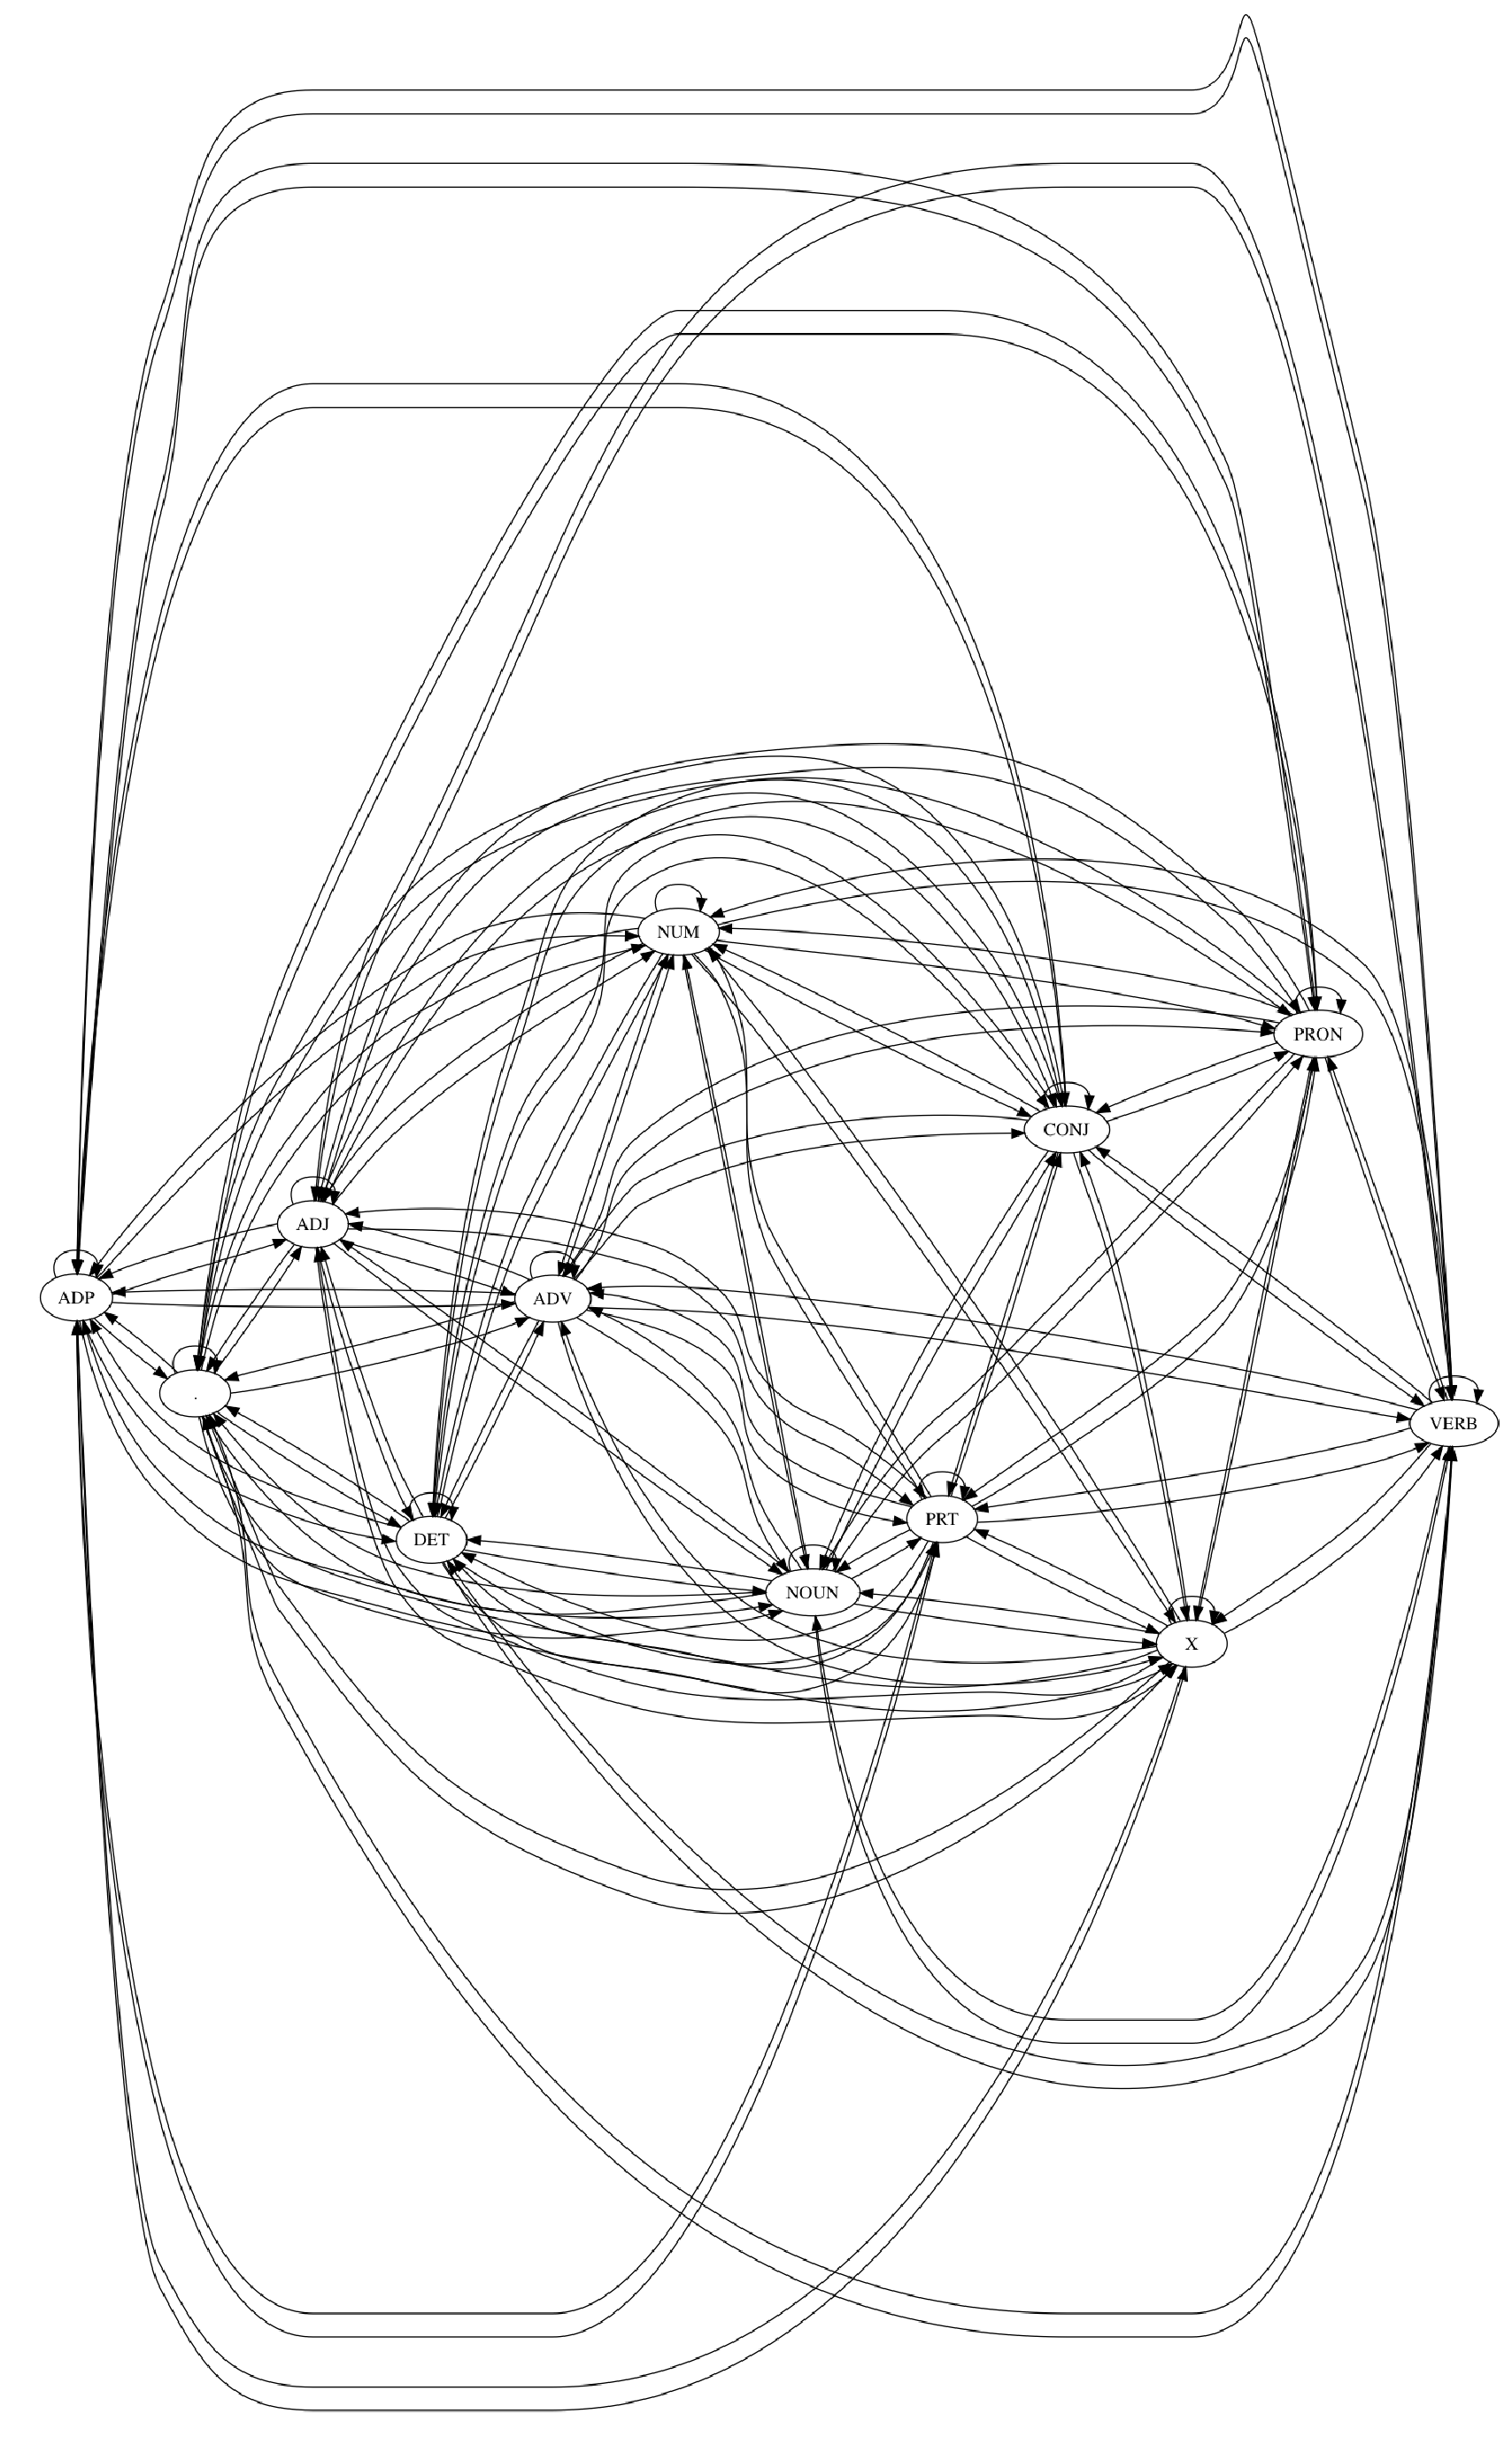

In [19]:
show_model(basic_model, figsize=(30, 50), filename="example.png", overwrite=True, show_ends=False)

In [20]:
hmm_training_acc = accuracy(data.training_set.X, data.training_set.Y, basic_model)
print("training accuracy basic hmm model: {:.2f}%".format(100 * hmm_training_acc))

hmm_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, basic_model)
print("testing accuracy basic hmm model: {:.2f}%".format(100 * hmm_testing_acc))

assert hmm_training_acc > 0.97, "Uh oh. Your HMM accuracy on the training set doesn't look right."
assert hmm_training_acc > 0.955, "Uh oh. Your HMM accuracy on the training set doesn't look right."
HTML('<div class="alert alert-block alert-success">Your HMM tagger accuracy looks correct! Congratulations, you\'ve finished the project.</div>')

training accuracy basic hmm model: 97.54%
testing accuracy basic hmm model: 96.16%


### Example Decoding Sequences with the HMM Tagger

In [21]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, basic_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', '.', 


## Finishing the project
---

<div class="alert alert-block alert-info">
**Note:** **SAVE YOUR NOTEBOOK**, then run the next cell to generate an HTML copy. You will zip & submit both this file and the HTML copy for review.
</div>

In [22]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook HMM Tagger.ipynb to html',
 '[NbConvertApp] Writing 1892679 bytes to HMM Tagger.html',
 '[NbConvertApp] Converting notebook HMM warmup (optional).ipynb to html',
 '[NbConvertApp] Writing 379405 bytes to HMM warmup (optional).html']

## Step 4: [Optional] Improving model performance
---
There are additional enhancements that can be incorporated into your tagger that improve performance on larger tagsets where the data sparsity problem is more significant. The data sparsity problem arises because the same amount of data split over more tags means there will be fewer samples in each tag, and there will be more missing data  tags that have zero occurrences in the data. The techniques in this section are optional.

- [Laplace Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) (pseudocounts)
    Laplace smoothing is a technique where you add a small, non-zero value to all observed counts to offset for unobserved values.

- Backoff Smoothing
    Another smoothing technique is to interpolate between n-grams for missing data. This method is more effective than Laplace smoothing at combatting the data sparsity problem. Refer to chapters 4, 9, and 10 of the [Speech & Language Processing](https://web.stanford.edu/~jurafsky/slp3/) book for more information.

- Extending to Trigrams
    HMM taggers have achieved better than 96% accuracy on this dataset with the full Penn treebank tagset using an architecture described in [this](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf) paper. Altering your HMM to achieve the same performance would require implementing deleted interpolation (described in the paper), incorporating trigram probabilities in your frequency tables, and re-implementing the Viterbi algorithm to consider three consecutive states instead of two.

### Obtain the Brown Corpus with a Larger Tagset
Run the code below to download a copy of the brown corpus with the full NLTK tagset. You will need to research the available tagset information in the NLTK docs and determine the best way to extract the subset of NLTK tags you want to explore. If you write the following the format specified in Step 1, then you can reload the data using all of the code above for comparison.

Refer to [Chapter 5](http://www.nltk.org/book/ch05.html) of the NLTK book for more information on the available tagsets.

In [25]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import brown

nltk.download('brown')
training_corpus = nltk.corpus.brown
training_corpus.tagged_sents()[0]

[nltk_data] Downloading package brown to
[nltk_data]     /Users/antelinvestigacionydesarrollo/nltk_data...
[nltk_data]   Package brown is already up-to-date!


[('The', 'AT'),
 ('Fulton', 'NP-TL'),
 ('County', 'NN-TL'),
 ('Grand', 'JJ-TL'),
 ('Jury', 'NN-TL'),
 ('said', 'VBD'),
 ('Friday', 'NR'),
 ('an', 'AT'),
 ('investigation', 'NN'),
 ('of', 'IN'),
 ("Atlanta's", 'NP$'),
 ('recent', 'JJ'),
 ('primary', 'NN'),
 ('election', 'NN'),
 ('produced', 'VBD'),
 ('``', '``'),
 ('no', 'AT'),
 ('evidence', 'NN'),
 ("''", "''"),
 ('that', 'CS'),
 ('any', 'DTI'),
 ('irregularities', 'NNS'),
 ('took', 'VBD'),
 ('place', 'NN'),
 ('.', '.')]

## First, let's test the basic model with the corpus.

### How many tags are in the corpus?

In [26]:
len({x[1] for x in training_corpus.tagged_words()})

472

Let's get the most common ones...

In [41]:
num_tags = 36
tag_fd = nltk.FreqDist(tag for (word, tag) in training_corpus.tagged_words())
common_tags_freq = tag_fd.most_common(num_tags)
common_tags_freq

[('NN', 152470),
 ('IN', 120557),
 ('AT', 97959),
 ('JJ', 64028),
 ('.', 60638),
 (',', 58156),
 ('NNS', 55110),
 ('CC', 37718),
 ('RB', 36464),
 ('NP', 34476),
 ('VB', 33693),
 ('VBN', 29186),
 ('VBD', 26167),
 ('CS', 22143),
 ('PPS', 18253),
 ('VBG', 17893),
 ('PP$', 16872),
 ('TO', 14918),
 ('PPSS', 13802),
 ('CD', 13510),
 ('NN-TL', 13372),
 ('MD', 12431),
 ('PPO', 11181),
 ('BEZ', 10066),
 ('BEDZ', 9806),
 ('AP', 9522),
 ('DT', 8957),
 ('``', 8837),
 ("''", 8789),
 ('QL', 8735),
 ('VBZ', 7373),
 ('BE', 6360),
 ('RP', 6009),
 ('WDT', 5539),
 ('HVD', 4895),
 ('*', 4603)]

In [31]:
print(training_corpus.readme())

BROWN CORPUS

A Standard Corpus of Present-Day Edited American
English, for use with Digital Computers.

by W. N. Francis and H. Kucera (1964)
Department of Linguistics, Brown University
Providence, Rhode Island, USA

Revised 1971, Revised and Amplified 1979

http://www.hit.uib.no/icame/brown/bcm.html

Distributed with the permission of the copyright holder,
redistribution permitted.



In [45]:
# Write the tagset file...
tagset = [x[0] for x in common_tags_freq]
with open('custom_tagset.txt', 'w') as file:
    file.write('\n'.join(tagset))

In [71]:
# Write the tagged words file. I use the 'nan' convention of Pomegranate
with open('custom_corpus.txt', 'w') as file:
    for i, sentence in enumerate(training_corpus.tagged_sents()):
        formatted_sentence = 'sentence_{:07d}\n'.format(i)
        formatted_sentence += '\n'.join(map(lambda x:'\t'.join(x) 
                                            if x[1] in tagset 
                                            else '\t'.join((x[0], 'nan')), sentence))
        formatted_sentence += '\n\n'
        file.write(formatted_sentence)

In [72]:
# Create the dataset
data = Dataset("custom_tagset.txt", "custom_corpus.txt", train_test_split=0.8)

In [73]:
# Minimal look at the dataset
print("There are a total of {} samples of {} unique words in the corpus."
      .format(data.N, len(data.vocab)))
print("There are {} samples of {} unique words in the training set."
      .format(data.training_set.N, len(data.training_set.vocab)))
print("There are {} samples of {} unique words in the testing set."
      .format(data.testing_set.N, len(data.testing_set.vocab)))
print("There are {} words in the test set that are missing in the training set."
      .format(len(data.testing_set.vocab - data.training_set.vocab)))

assert data.N == data.training_set.N + data.testing_set.N, \
       "The number of training + test samples should sum to the total number of samples"

There are a total of 1161192 samples of 56057 unique words in the corpus.
There are 925277 samples of 50339 unique words in the training set.
There are 235915 samples of 25435 unique words in the testing set.
There are 5718 words in the test set that are missing in the training set.


In [74]:
print('Emission counts...')
words, tags = list(zip(*data.stream()))
emission_counts = pair_counts(tags, words)
print('Unigrams...')
tag_unigrams = unigram_counts(data.training_set.Y)
print('Bigrams...')
tag_bigrams = bigram_counts(data.training_set.Y)
print('Starts...')
tag_starts = starting_counts(data.training_set.Y)
print('Ends...')
tag_ends = ending_counts(data.training_set.Y)

Emission counts...
Unigrams...
Bigrams...
Starts...
Ends...


In [78]:
data.tagset

frozenset({"''",
           '*',
           ',',
           '.',
           'AP',
           'AT',
           'BE',
           'BEDZ',
           'BEZ',
           'CC',
           'CD',
           'CS',
           'DT',
           'HVD',
           'IN',
           'JJ',
           'MD',
           'NN',
           'NN-TL',
           'NNS',
           'NP',
           'PP$',
           'PPO',
           'PPS',
           'PPSS',
           'QL',
           'RB',
           'RP',
           'TO',
           'VB',
           'VBD',
           'VBG',
           'VBN',
           'VBZ',
           'WDT',
           '``'})

### Let's test the same basic tagger idea with this tagset

In [75]:
basic_model = HiddenMarkovModel(name="baseline")

# TODO: create states with emission probability distributions P(word | tag) and add to the model
# (Hint: you may need to loop & create/add new states)
states = [
    State(DiscreteDistribution({key: value / tag_unigrams[tag] 
                                for key, value in emission_counts[tag].items()}), tag)
    for tag in data.training_set.tagset
]
basic_model.add_states(*states)

# TODO: add edges between states for the observed transition frequencies P(tag_i | tag_i-1)
# (Hint: you may need to loop & add transitions

# Starting tag
N_sentences = len(data.training_set.sentences)
for state in states:
    basic_model.add_transition(basic_model.start, 
                               state, 
                               tag_starts[state.name] / N_sentences)
    basic_model.add_transition(state, 
                               basic_model.end, 
                               tag_ends[state.name] / tag_unigrams[state.name])
    for state2 in states:
        basic_model.add_transition(state, 
                                   state2, 
                                   tag_bigrams[(state.name, state2.name)] / tag_unigrams[state.name])

# finalize the model
basic_model.bake()

assert all(tag in set(s.name for s in basic_model.states) for tag in data.training_set.tagset), \
       "Every state in your network should use the name of the associated tag, which must be one of the training set tags."
print(basic_model.edge_count())

KeyError: ('CS', 'BE')

In [79]:
tag_bigrams

{('QL', 'AP'): 452,
 ('NNS', 'JJ'): 414,
 ('HVD', 'DT'): 12,
 ('nan', 'WDT'): 211,
 ('QL', 'CD'): 2,
 ('VBD', 'CD'): 252,
 ('NN-TL', 'AP'): 14,
 ('WDT', 'MD'): 288,
 ('VB', 'VBN'): 140,
 ('JJ', 'AP'): 63,
 ('JJ', '``'): 124,
 ('AT', 'RB'): 274,
 ('AP', 'PP$'): 3,
 ('DT', 'VBG'): 41,
 ('PPO', 'BEDZ'): 40,
 ('CS', 'HVD'): 8,
 ('NP', 'NP'): 6022,
 ('BEDZ', 'AP'): 41,
 ('CD', 'AT'): 62,
 ('*', 'NP'): 15,
 ('VB', '*'): 33,
 ('BEZ', '.'): 28,
 ('RP', 'NN-TL'): 4,
 ('nan', 'RP'): 130,
 ('NP', 'TO'): 175,
 ('JJ', ','): 2804,
 ('RP', 'VBZ'): 1,
 ('BEZ', 'CS'): 187,
 ('AP', 'VBZ'): 9,
 ('JJ', 'PP$'): 28,
 ('HVD', 'NP'): 19,
 ('RP', 'VBG'): 38,
 ('AT', 'AT'): 1,
 ('VBG', 'CD'): 96,
 ('VBG', 'nan'): 636,
 ('AP', 'NP'): 72,
 ('BE', 'PPSS'): 1,
 ('CS', 'PPO'): 37,
 ('WDT', 'PPS'): 392,
 ('PP$', 'AP'): 105,
 ('BEZ', 'QL'): 430,
 ('NNS', 'TO'): 729,
 ('WDT', 'AP'): 22,
 ('NNS', 'PPSS'): 215,
 ('CC', 'BEDZ'): 151,
 ('IN', 'VB'): 32,
 ('nan', 'JJ'): 3565,
 ('AT', 'MD'): 1,
 ('JJ', 'VBZ'): 21,
 ('PP$', '